## netCDF: Importing netCDF files, extracting desired data and bringing it into a desired format

In this file I will itterativly try to load and understand the structure of the by anemos delivered netCDF wind data.

1. I am going to install and load all the necessary packages to work with and analyse netCDF data

In [1]:
import xarray as xr
import timeit
import pandas as pd
import numpy as np
import numba
#import asyncio
#import hvplot.xarray
import cartopy.crs as ccrs
import sys

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return size, power_labels[n]+'bytes'

import matplotlib.pyplot as plt

print(xr.__version__)

0.20.2


# Loading a netCDF file with the xarray package

In [ ]:
#path = r"windData/wdirC.7L.2017-T.ts.nc"
year = 2017
nc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/NC-Format/wspd.10L.{year}.nc"
tsnc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.{year}.ts.nc"

start = timeit.default_timer()

data = xr.open_dataset(nc_data_path, chunks={'time': 100}, engine='h5netcdf')
# for multiple files
#data = xr.open_mfdataset(nc_data_path, chunks={'time': 100}, parallel=True, engine='h5netcdf')

stop = timeit.default_timer()

print(f'Loadingtme for netCDF-file: {stop - start}')
size = format_bytes(sys.getsizeof(data))
print(f"Size of loaded file: {size}")
data

## Replace `x,y` Dimensions 

Initially the `x,y` dimensions of the netCDF file where ranging from 0 to the number of raw or column. The grid is structured as a *lambert projection*, but the absolut values of `0,...` do not represent the correct coordinates. Therefore,  anemos send us the correct lambert projection coordinates, in order to assign them to the `x,y` dimensions. 

With the result we should be able to transform a `lon,lat` coordinate *(EPSG=4326)* to a lambert projection coordinate.

In [ ]:
# Load the new dimensional lambda coordinates
path = "xy_lamber_projection_values"

new_dim_coor = pd.read_csv(path)
new_dim_coor.head()

In [ ]:
# assign the new x,y values to the netCDF data
x = new_dim_coor["x"].dropna().astype("int").values
y = new_dim_coor["y"].values

data = data.assign_coords(
    coords={"x": x,"y": y}
)

### Using coordination transformation with projections to get exact `[x,y]` float equivalents to the multidimensional `[lon(x,y),lat(x,y)]`

#### *cartopy*: **NOT WORKING (same for anemos)**

In [ ]:
map_proj = ccrs.LambertConformal(
    central_longitude=data.CEN_LON[0], 
    central_latitude=data.CEN_LAT[0], 
    #false_easting=,
    #false_northing=,
    standard_parallels=(data.MOAD_CEN_LAT[0], data.STAND_LON[0]),
    #globe=None,
    #cutoff=-30
    )

x, y = map_proj.transform_point(47.2, 5.899, src_crs=ccrs.PlateCarree())
print(f"x:{x}, y:{y}")

#### *pyproj*: **WORKING (code and new `x,y` coordinates from anemos)**

In [ ]:
from pyproj import CRS, Transformer

crsD3E5 = CRS.from_proj4("+proj=lcc +lat_1=48.0 +lat_2=54.0 +lat_0=50.893 +lon_0=10.736 +a=6370000 +b=6370000 +nadgrids=null +no_defs")
crsGeo = CRS.from_epsg(4326)
geo2altas = Transformer.from_crs(crsGeo, crsD3E5)
lon = 10.0
lat = 50.0

#lon = point["coor"][1]
#lat = point["coor"][0]

x,y = geo2altas.transform(lat, lon)
print(f"x:{x}, y:{y}")
data.interp(x=x,y=y,level=110,time=f"{year}-03-29T19:30").load()

#### *gdal*: **WORKING (code and new `x,y` coordinates from anemos)**

In [ ]:
import ogr
import osr
d3e5Prj = osr.SpatialReference()
d3e5Prj.ImportFromProj4("+proj=lcc +lat_1=48.0 +lat_2=54.0 +lat_0=50.893 +lon_0=10.736 +a=6370000 +b=6370000 +nadgrids=null +no_defs")
geoPrj = osr.SpatialReference()
geoPrj.ImportFromEPSG(4326)
lon = 10.0
lat = 50.0

#lon = point["coor"][1]
#lat = point["coor"][0]

point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(lat, lon)
point.AssignSpatialReference(geoPrj)    # tell the point what coordinates it's in
point.TransformTo(d3e5Prj)              # project it to the out spatial reference
print(f'{point.GetX()},{point.GetY()}')
data.interp(x=point.GetX(),y=point.GetY(),level=110,time=f"{year}-03-29T19:30").load()

## Putting together a function to perform the coordinate transformation

In [2]:
def coor_transformation(coor:list,engine:str="pyproj")->list:
    lambert_proj_str = "+proj=lcc +lat_1=48.0 +lat_2=54.0 +lat_0=50.893 +lon_0=10.736 +a=6370000 +b=6370000 +nadgrids=null +no_defs"

    if engine == "pyproj":
        from pyproj import CRS, Transformer

        crsD3E5 = CRS.from_proj4(lambert_proj_str)
        crsGeo = CRS.from_epsg(4326)
        geo2altas = Transformer.from_crs(crsGeo, crsD3E5)

        x,y = geo2altas.transform(coor[0], coor[1])
        return[x,y]

    if engine == "gdal":
        from ogr import Geometry
        from osr import SpatialReference
        
        d3e5Prj = SpatialReference()
        d3e5Prj.ImportFromProj4(lambert_proj_str)
        geoPrj = SpatialReference()
        geoPrj.ImportFromEPSG(4326)

        point = Geometry(ogr.wkbPoint)
        point.AddPoint(coor[0], coor[1])
        point.AssignSpatialReference(geoPrj)    # tell the point what coordinates it's in
        point.TransformTo(d3e5Prj)              # project it to the out spatial reference
        return[point.GetX(),point.GetY()]

# Trying Coordinate Search

In [ ]:
ds = data.sel(level=120,time=f"{year}-03-29T19:30")
ds.wspd.plot(x='lon', y='lat', figsize=(13,13))
plt.scatter(ds.lon, ds.lat, s = 0.2)

In [ ]:
# A 2D plot of the SPEED variable, assigning the coordinate values,
# and plot the verticies of each point
dsplot = ds.where((lon-0.1 < data.lon) & (data.lon < lon+0.1) & (lat-0.1 < data.lat) & (data.lat < lat+0.1), drop=True)
dsplot.wspd.plot(x='lon', y='lat', figsize=(6,6))
plt.scatter(dsplot.lon, dsplot.lat)#, s = 0.2)

lon = 10.0
lat = 50.0

[x_interp,y_interp] = coor_transformation(coor=[lat,lon])
#print(x_interp,y_interp)

# Plot requested lat/lon point blue
plt.scatter(lon, lat, color='b')
plt.text(lon, lat, 'requested')

# Plot nearest point in the array red
ds_near = ds.interp(x=x_interp, y=y_interp, method="nearest")
plt.scatter(ds_near.lon, ds_near.lat, color='r')
plt.text(ds_near.lon, ds_near.lat, 'nearest')
#ds_near.load()

# Plot interpolation value
ds_interp = ds.interp(x=x_interp, y=y_interp, method="linear")
plt.scatter(ds_interp.lon, ds_interp.lat, color='y', marker="x")
plt.text(ds_interp.lon, ds_interp.lat, 'interp')
ds_interp.load()

plt.title('speed at nearest interpolated point: %s' % ds_interp.wspd.data)

## Plotting time series

### mfdataset Xarray

In [ ]:
# .nc data
year = 2017
lon = 10.0
lat = 50.
[x_interp,y_interp] = coor_transformation(coor=[lat,lon], engine="pyproj")

# Load the new dimensional lambda coordinates
path = "xy_lamber_projection_values"
new_dim_coor = pd.read_csv(path)
# assign the new x,y values to the netCDF data
x = new_dim_coor["x"].dropna().astype("int").values
y = new_dim_coor["y"].values

# netCDF windatlas files
nc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/NC-Format/wspd.10L.{year}.nc"
#nc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/NC-Format/wspd.10L.*.nc"

with xr.open_mfdataset(nc_data_path, chunks={'time': 1000}, engine='h5netcdf', parallel=True) as nc_data:
    # assign the new x,y values to the netCDF data
    nc_data = nc_data.assign_coords(
        coords={"x": x,"y": y}
    )

    ts_interp = nc_data.interp(x=x_interp, y=y_interp, level=113, method="linear")

ts_interp#.wspd#.load().plot.line()

### not "mf"-dataset, instead list comprehension

In [ ]:
# .ts.nc data
years = np.arange(2009,2019,1)
#year = 2017
lon = 10.0
lat = 50.0
[x_interp,y_interp] = coor_transformation(coor=[lat,lon], engine="pyproj")

# load the new dimensional lambda coordinates
path = "xy_lamber_projection_values"
new_dim_coor = pd.read_csv(path)
# load the new x,y values to the netCDF data
x = new_dim_coor["x"].dropna().astype("int").values
y = new_dim_coor["y"].values

#@numba.jit(nopython=True)
def loading_year(
        year:int, 
        x:np.ndarray=x, 
        y:np.ndarray=y,
        x_interp:float=x_interp,
        y_interp:float=y_interp
        ):

    tsnc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.{year}.ts.nc"

    with xr.open_dataset(tsnc_data_path,engine='h5netcdf') as ts_nc_data:
        # assign the new x,y values to the netCDF data
        ts_nc_data = ts_nc_data.assign_coords(
            coords={"x": x,"y": y}
        )

        ts_interp = ts_nc_data.interp(x=x_interp, y=y_interp, level=113, method="linear")

    return ts_interp.wspd.load()

start = timeit.default_timer()

arrays = [loading_year(year=year) for year in years]

ts_interp = xr.concat(arrays, dim="time")

stop = timeit.default_timer()

del(arrays)
print(f'concattime for netCDF-query: {stop - start}')

ts_interp#.wspd#.plot.line(figsize=(13,5))

In [ ]:
type(ts_interp)

### not "mf"-dataset, instead for loop

In [ ]:
# .ts.nc data
years = np.arange(2009,2019,1)
#year = 2017
lon = 10.0
lat = 50.0
[x_interp,y_interp] = coor_transformation(coor=[lat,lon], engine="pyproj")

# load the new dimensional lambda coordinates
path = "xy_lamber_projection_values"
new_dim_coor = pd.read_csv(path)
# load the new x,y values to the netCDF data
x = new_dim_coor["x"].dropna().astype("int").values
y = new_dim_coor["y"].values

# netCDF windatlas files
#tsnc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.{year}.ts.nc"
#tsnc_data_path = "/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.*.ts.nc"

arrays = list()

for year in years:
    tsnc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.{year}.ts.nc"
    with xr.open_dataset(tsnc_data_path,engine='h5netcdf') as ts_nc_data:
        # assign the new x,y values to the netCDF data
        ts_nc_data = ts_nc_data.assign_coords(
            coords={"x": x,"y": y}
        )

        ts_interp = ts_nc_data.interp(x=x_interp, y=y_interp, level=113, method="linear")
    
    arrays.append(ts_interp.wspd.load())

start = timeit.default_timer()

ts_interp = xr.concat(arrays, dim="time")

stop = timeit.default_timer()

del(arrays)
print(f'concattime for netCDF-query: {stop - start}')

ts_interp#.wspd#.plot.line(figsize=(13,5))

In [ ]:
ts_interp.resample(time="7d").mean().plot(figsize=(20,3))

In [ ]:
# Export query to new netCDF File
path = "./temp/ts_temp.nc"
#ts_interp.wspd.to_netcdf(path)

In [ ]:
test = xr.open_dataset(
    path,
    engine='h5netcdf'
)
test.wspd.plot.line()

### Multiprocessing

In [4]:
# .ts.nc data
years = np.arange(2009,2019,1)
#year = 2017
lon = 10.0
lat = 50.0
[x_interp,y_interp] = coor_transformation(coor=[lat,lon], engine="pyproj")

# load the new dimensional lambda coordinates
path = "xy_lamber_projection_values"
new_dim_coor = pd.read_csv(path)
# load the new x,y values to the netCDF data
x = new_dim_coor["x"].dropna().astype("int").values
y = new_dim_coor["y"].values

#@numba.jit(nopython=True)
def loading_year(
        #liste:list,
        year:int, 
        x:np.ndarray=x, 
        y:np.ndarray=y,
        x_interp:float=x_interp,
        y_interp:float=y_interp
        )->xr.DataArray:

    tsnc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.{year}.ts.nc"

    with xr.open_dataset(tsnc_data_path,engine='h5netcdf') as ts_nc_data:
        # assign the new x,y values to the netCDF data
        ts_nc_data = ts_nc_data.assign_coords(
            coords={"x": x,"y": y}
        )

        ts_interp = ts_nc_data.interp(x=x_interp, y=y_interp, level=113, method="linear")

    #liste.append(ts_interp.wspd.load())
    return ts_interp.wspd.load()

In [ ]:
from multiprocessing import Process, Manager

start = timeit.default_timer()

with Manager() as manager:
    L = manager.list()  # <-- can be shared between processes.
    processes = []
    for year in years:
        p = Process(target=loading_year, args=(L,year))  # Passing the list
        p.start()
        processes.append(p)
    for p in processes:
        p.join()

    ts_interp = xr.concat(L, dim="time")

stop = timeit.default_timer()

print(f'concattime for netCDF-query: {stop - start}')

ts_interp#.wspd#.plot.line(figsize=(13,5))

In [8]:
import concurrent

years = list(range(2009,2019,1))

start = timeit.default_timer()

with concurrent.futures.ProcessPoolExecutor() as executor:
    array = executor.map(loading_year, years)

ts_interp = xr.concat(array, dim="time")

stop = timeit.default_timer()

print(f'concattime for netCDF-query: {stop - start}')

ts_interp#.wspd#.plot.line(figsize=(13,5))

concattime for netCDF-query: 7.438103784807026


<xarray.DataArray 'wspd' (time: 525888)>
array([1.18328624, 1.21161656, 1.26250741, ..., 4.95468295, 4.90085667,
       4.87707435])
Coordinates:
    lat      float64 50.0
    lon      float64 10.0
  * time     (time) datetime64[ns] 2009-01-01 ... 2018-12-31T23:50:00
    x        float64 -5.253e+04
    y        float64 -9.889e+04
    level    int64 113
Attributes:
    long_name:    windspeed remodelled
    description:  windspeed remodelled
    version:      D-3km.E5 Rem V2
    units:        m/s
    var_desc:     Wind Speed\n

In [10]:
from multiprocessing import Pool

#years = list(range(2009,2019,1))

start = timeit.default_timer()

proc_pool = Pool(8)

with Pool(8) as proc_pool:
    array = proc_pool.map(loading_year, range(2009,2019,1))
    proc_pool.close()
    proc_pool.join()

    ts_interp = xr.concat(array, dim="time")

stop = timeit.default_timer()

print(f'concattime for netCDF-query: {stop - start}')

ts_interp#.wspd#.plot.line(figsize=(13,5))

concattime for netCDF-query: 7.113919485127553


<xarray.DataArray 'wspd' (time: 525888)>
array([1.18328624, 1.21161656, 1.26250741, ..., 4.95468295, 4.90085667,
       4.87707435])
Coordinates:
    lat      float64 50.0
    lon      float64 10.0
  * time     (time) datetime64[ns] 2009-01-01 ... 2018-12-31T23:50:00
    x        float64 -5.253e+04
    y        float64 -9.889e+04
    level    int64 113
Attributes:
    long_name:    windspeed remodelled
    description:  windspeed remodelled
    version:      D-3km.E5 Rem V2
    units:        m/s
    var_desc:     Wind Speed\n

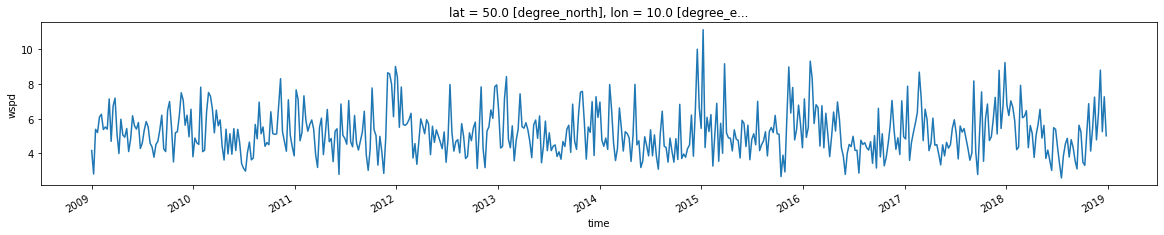

In [11]:
ts_interp.resample(time="7d").mean().plot(figsize=(20,3))

## Queing multiple Points
### xr.interp

In [27]:
year = 2017
tsnc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.{year}.ts.nc"

points = [[2,4],[3,3],[4,2]]

with xr.open_dataset(tsnc_data_path,engine='h5netcdf') as ts_nc_data:
    # assign the new x,y values to the netCDF data
    ts_nc_data = ts_nc_data.assign_coords(
        coords={"x": x,"y": y}
    )
    
    data = list()
    for point in points:
        ts_interp = ts_nc_data.interp(x=point[0], y=point[1], level=113, method="linear")
        data.append(ts_interp)

data

[<xarray.Dataset>
 Dimensions:  (time: 52560)
 Coordinates:
     lat      float64 50.89
     lon      float64 10.74
   * time     (time) datetime64[ns] 2017-01-01 ... 2017-12-31T23:50:00
     x        int64 2
     y        int64 4
     level    int64 113
 Data variables:
     wspd     (time) float64 7.609 7.523 7.453 7.37 ... 13.15 13.11 13.0 12.79
 Attributes: (12/130)
     TITLE:                           D3E5
     START_DATE:                      2011-07-01_00:00:00
     SIMULATION_START_DATE:           2010-01-01_00:00:00
     WEST-EAST_GRID_DIMENSION:        [256]
     SOUTH-NORTH_GRID_DIMENSION:      [352]
     BOTTOM-TOP_GRID_DIMENSION:       [50]
     ...                              ...
     ISOILWATER:                      [14]
     history:                         Thu Aug  8 14:07:48 2019: ncrcat -7 -L 3...
     NCO:                             4.4.2
     title:                           D3E5
     nco_openmp_thread_number:        [1]
     actual_range:                    [10

In [29]:
import os
print (os.getcwd())

/home/eouser/Documents/code/Windatlas/windatlas/anemos_data/transfer


# 2. yearly average data

The averaged data contains wind statistics of each coordinate at a certain level. In 12 directional subclases, both the average windspeed and the dominant wind direction is given.

In [ ]:
def circularHisto(xarray, dataVariable:str, grid=False):
    '''
    To Do's:
    - Add colorbar
    '''
    radii = xarray[dataVariable].values
    N = radii.size
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    width = np.full((1, 12), 2 * np.pi / 13)[0]
    
    ax = plt.subplot(111, projection='polar')
    bars = ax.bar(theta, radii, bottom=0.0, width=width)
    # Use custom colors and opacity
    for r, bar in zip(radii, bars):
        bar.set_facecolor(plt.cm.viridis(r / radii.max()))
        bar.set_alpha(0.7)

    ax.set_theta_zero_location("N")
    if grid:
        ax.set_rticks(np.arange(0,radii.max(),2))
    else:
        ax.set_rticks([])
    
    ticks = ["N","NW","W","SW","S","SE","E","NE"]
    ax.set_xticklabels(ticks)
    
    if dataVariable == "wspd":
        ax.set_title("Average Windspeed [m/s] 2008 - 2017", pad=25)
        
    if dataVariable == "histo":
        ax.set_title("Distribution of wind directions 2008 - 2017", pad=25)
    plt.show()
    
def describingHisto(xarray):
    fig, axs = plt.subplots(1, 2)
    
    diags =("histo","wspd")
    
    for num, ax in enumerate(axs):
        ax = circularHisto(xarray, dataVariable=diags[num])

In [ ]:
path = r"windData/D-3km.E5.dirStats.140m.2008-2017.nc"

data120m = xr.open_dataset(path)
data120m

In [ ]:
point = {
    "level":114,
    "y":0,
    "x":0,
    "coor":[50,10],
    "time":pd.to_datetime(["2016-05-01"])
}

start = timeit.default_timer()

([yloc], [xloc]), nlevel  = findPoint(data120m, point)

mid = timeit.default_timer()

point_stat = getPointData(xarray=data120m, x=xloc, y=yloc)

end = timeit.default_timer()

point["x"] = xloc
point["y"] = yloc

print(f'Nearest point: {point["x"]},{point["y"]}')
print(f'Nearest point coordinates: {point_stat.lon.values},{point_stat.lat.values}')
print(f'Time to find nearest point: {mid - start}')
print(f'Time to find get point data: {end - mid}')

point_stat

In [ ]:
circularHisto(point_stat, dataVariable="histo")
circularHisto(point_stat, dataVariable="wspd", grid=True)

In [ ]:
import numpy as np
import numba
from numba import cuda, f8, uint8

n = 20
dk = 0.00001

In [ ]:

def frange(n=n, dk =dk):
    dk = dk
    X = np.arange(dk, n, dk)
    outerSum = 0
    for i in range(X.shape[0]):
        k = X[i]
        outerSum += k

%timeit frange()


In [ ]:
@numba.jit(nopython=True)
def farange(n=n, dk =dk):
    dk = dk
    #X = np.arange(dk, n, dk)
    outerSum = 0
    for i in np.arange(dk, n, dk):
        outerSum += i

%timeit farange()

In [ ]:
@numba.jit(nopython=True)
def nbrange(n=n, dk =dk):
    dk = dk
    X = np.arange(dk, n, dk)
    outerSum = 0
    for i in range(X.shape[0]):
        k = X[i]
        outerSum += k

%timeit nbrange()

In [ ]:
@cuda.jit(argtypes=[f8, uint8])
def cudarange(n=n, dk =dk):
    dk = dk
    X = np.arange(dk, n, dk)
    outerSum = 0
    for i in range(X.shape[0]):
        k = X[i]
        outerSum += k

%timeit cudarange()